# Flight Delay Analysis

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from typing import Optional
%matplotlib inline

In [ ]:
# load data
path = 'notebook_data/*.csv'

# Use glob to get all CSV file paths
all_files = glob.glob(path)

# Read and concatenate all CSV files into a single DataFrame
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [ ]:
df.head(10)

In [ ]:
df[df["ORIGIN_CITY_NAME"] == "Milwaukee, WI"]

In [ ]:
df[(df["ORIGIN_CITY_NAME"] == "Milwaukee, WI") & (df["DAY_OF_MONTH"] == 24)]

In [ ]:
# plot the number of flights by day
def get_num_flights(day, city):
    return len(df[(df["ORIGIN_CITY_NAME"] == city) & (df["DAY_OF_MONTH"] == day)])

In [ ]:
cities = ['Milwaukee, WI', 'San Diego, CA', 'San Francisco, CA']

for city in cities:
    days = range(1, 32)
    num_flights = [get_num_flights(day, city) for day in days]
    
    plt.figure(figsize=(12, 6))
    plt.plot(days, num_flights, 'b-', label='Number of Flights')

    # Mark day 24 with a red dot
    plt.plot(24, get_num_flights(24, city), 'ro', markersize=10, label='XMas Eve')

    # Customize the plot
    plt.title(f'Number of Flights by Day of Month {city} December 2018-2023', fontsize=16)
    plt.xlabel('Day of Month', fontsize=12)
    plt.ylabel('Number of Flights', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Set x-axis ticks to show all days
    plt.xticks(days)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_delay_probability_with_cancellation(filtered_df, delay, city):
    filtered_df = filtered_df[filtered_df["ORIGIN_CITY_NAME"] == city]
    num_delayed_or_cancelled = len(filtered_df[(filtered_df["ARR_DELAY"] >= delay) | (filtered_df["CANCELLED"] == True) | (filtered_df["DIVERTED"] == True)])
    return num_delayed_or_cancelled / len(filtered_df)

In [ ]:
def compute_delay_probability_without_cancellation(filtered_df, delay, city):
    filtered_df = filtered_df[filtered_df["ORIGIN_CITY_NAME"] == city]
    not_cancelled = filtered_df[(filtered_df["CANCELLED"] == False) & (filtered_df["DIVERTED"] == False)]
    num_delayed = len(not_cancelled[(not_cancelled["ARR_DELAY"] >= delay)])
    return num_delayed / len(not_cancelled)

In [ ]:
cities = ['Milwaukee, WI', 'San Diego, CA', 'San Francisco, CA']

for city in cities:
    filtered_df = df[df["ORIGIN_CITY_NAME"] == city]
    xmas_eve_df = filtered_df[filtered_df["DAY_OF_MONTH"] == 24]
    max_delay = 250  # override

    delays = np.arange(0, max_delay + 1)

    december_probabilities = [compute_delay_probability_without_cancellation(filtered_df, delay, city) for delay in delays]
    xmas_eve_probabilities = [compute_delay_probability_without_cancellation(xmas_eve_df, delay, city) for delay in delays]

    plt.figure(figsize=(14, 7))

    plt.plot(delays, december_probabilities, 'b-', label='December')
    plt.plot(delays, xmas_eve_probabilities, 'r-', label='Xmas Eve')

    december_prob_1h = december_probabilities[60]
    xmas_eve_prob_1h = xmas_eve_probabilities[60]

    plt.axhline(y=december_prob_1h, color='b', linestyle=':', xmin=0)
    plt.axhline(y=xmas_eve_prob_1h, color='r', linestyle=':', xmin=0)

    plt.plot(60, december_prob_1h, 'bo', markersize=8)
    plt.plot(60, xmas_eve_prob_1h, 'ro', markersize=8)

    plt.annotate(f'{december_prob_1h:.2%}', (60, december_prob_1h), xytext=(0, 10), 
                 textcoords='offset points', ha='center', va='bottom', color='b')
    plt.annotate(f'{xmas_eve_prob_1h:.2%}', (60, xmas_eve_prob_1h), xytext=(0, 10), 
                 textcoords='offset points', ha='center', va='bottom', color='r')

    plt.title(f'Delay Probability (without Cancellations) vs. Delay Duration {city} 2018-2023', fontsize=16)
    plt.xlabel('Delay (hours:minutes)', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.ylim(0, 0.5)
    plt.yticks(np.arange(0, 0.51, 0.1))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.legend(fontsize=10)

    def format_time(x, pos):
        hours = int(x // 60)
        minutes = int(x % 60)
        return f'{hours:02d}:{minutes:02d}'

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
    plt.xticks(np.arange(0, max_delay + 1, 30), rotation=45)

    plt.xlim(0, max_delay * 1.05)

    plt.tight_layout()
    plt.show()

## Analysis on Full Data
We load the full data and investigate distributions of delays conditioned on various variables. Our goal is to find a generalized parameterized model for the delay distribution so that we can store the parameters for this model for each conditional.

First, we look to prune the raw data (columns and rows) to what we minimally need. This logic will be ported to a file to cache pruned data. Then, we carry out analysis on the resulting df.

In [7]:
data_dir = "data/"

In [8]:
# read data frame from all csv files in the data_dir
def read_data(data_dir):
    path = os.path.join(data_dir, '*.csv')
    all_files = glob.glob(path)
    return pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [9]:
df = read_data(data_dir)

In [10]:
df.head(10)

,FL_DATE,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,ARR_DELAY,CANCELLED,DIVERTED
0,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10423,1042302.0,30423.0,755.0,-5.0,0.0,0.0
1,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10423,1042302.0,30423.0,1545.0,5.0,0.0,0.0
2,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10800,1080003.0,32575.0,1230.0,-18.0,0.0,0.0
3,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10821,1082106.0,30852.0,1415.0,-2.0,0.0,0.0
4,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,600.0,-12.0,0.0,0.0
5,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1005.0,-4.0,0.0,0.0
6,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1130.0,-8.0,0.0,0.0
7,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1405.0,0.0,0.0,0.0
8,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1705.0,14.0,0.0,0.0
9,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11292,1129202.0,30325.0,640.0,-4.0,0.0,0.0


In [15]:
# add a new column bucketing the departure time into morning, afternoon, evening, and night
# range left inclusive, right exclusive
BUCKETS = {
    'morning': (600, 1200),
    'afternoon': (1200, 1800),
    'evening': (1800, 2400),
    'night': (0, 600),
}

def get_bucket(hour: Optional[float]) -> Optional[str]:
    if hour is None:
        return None
    for bucket, (start, end) in BUCKETS.items():
        if start <= hour < end:
            return bucket

df['DEP_TIME_BUCKET'] = df['CRS_DEP_TIME'].apply(get_bucket)

In [16]:
df.head(10)

,FL_DATE,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,ARR_DELAY,CANCELLED,DIVERTED,DEP_TIME_BUCKET
0,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10423,1042302.0,30423.0,755.0,-5.0,0.0,0.0,morning
1,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10423,1042302.0,30423.0,1545.0,5.0,0.0,0.0,afternoon
2,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10800,1080003.0,32575.0,1230.0,-18.0,0.0,0.0,afternoon
3,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,10821,1082106.0,30852.0,1415.0,-2.0,0.0,0.0,afternoon
4,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,600.0,-12.0,0.0,0.0,morning
5,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1005.0,-4.0,0.0,0.0,morning
6,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1130.0,-8.0,0.0,0.0,morning
7,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1405.0,0.0,0.0,0.0,afternoon
8,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11259,1125904.0,30194.0,1705.0,14.0,0.0,0.0,afternoon
9,5/1/2024 12:00:00 AM,19393.0,10140,1014005.0,30140.0,11292,1129202.0,30325.0,640.0,-4.0,0.0,0.0,morning


In [17]:
# filter out any cancelled or diverted flights
filtered_df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]

In [18]:
len(filtered_df)

33732081

In [19]:
# only keep the columns we need
columns_needed = [
    'OP_CARRIER_AIRLINE_ID',
    'ORIGIN_AIRPORT_ID',
    'DEST_AIRPORT_ID',
    'DEP_TIME_BUCKET',
    'ARR_DELAY',
]

filtered_df = filtered_df[columns_needed]

In [20]:
filtered_df.head(10)

,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME_BUCKET,ARR_DELAY
0,19393.0,10140,10423,morning,-5.0
1,19393.0,10140,10423,afternoon,5.0
2,19393.0,10140,10800,afternoon,-18.0
3,19393.0,10140,10821,afternoon,-2.0
4,19393.0,10140,11259,morning,-12.0
5,19393.0,10140,11259,morning,-4.0
6,19393.0,10140,11259,morning,-8.0
7,19393.0,10140,11259,afternoon,0.0
8,19393.0,10140,11259,afternoon,14.0
9,19393.0,10140,11292,morning,-4.0


In [21]:
# filter out any rows with missing values
filtered_df = filtered_df.dropna()
len(filtered_df)

33731726

In [22]:
# cast the OP_CARRIER_AIRLINE_ID to int
filtered_df['OP_CARRIER_AIRLINE_ID'] = filtered_df['OP_CARRIER_AIRLINE_ID'].astype(int)

In [23]:
filtered_df.head(10)

,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_TIME_BUCKET,ARR_DELAY
0,19393,10140,10423,morning,-5.0
1,19393,10140,10423,afternoon,5.0
2,19393,10140,10800,afternoon,-18.0
3,19393,10140,10821,afternoon,-2.0
4,19393,10140,11259,morning,-12.0
5,19393,10140,11259,morning,-4.0
6,19393,10140,11259,morning,-8.0
7,19393,10140,11259,afternoon,0.0
8,19393,10140,11259,afternoon,14.0
9,19393,10140,11292,morning,-4.0


In [36]:
# group by col and gather counts. Order by greatest to least
COL = 'DEP_TIME_BUCKET'
counts = filtered_df.groupby(COL).size().sort_values(ascending=False)
len(counts)

4

In [37]:
counts

DEP_TIME_BUCKET
morning      13203891
afternoon    12170577
evening       7456622
night          899229
dtype: int64

In [30]:
SINGLE_CONDITIONAL_FILTER = 200
# group by orig airport id and gather counts. filter out any airports with less than 200 flights
orig_airport_counts = filtered_df.groupby('ORIGIN_AIRPORT_ID').size()
filtered_orig_airport_counts = orig_airport_counts[orig_airport_counts >= SINGLE_CONDITIONAL_FILTER]
filtered_df = filtered_df[filtered_df['ORIGIN_AIRPORT_ID'].isin(filtered_orig_airport_counts.index)]

In [31]:
len(filtered_df)

33731024

In [32]:
# do the same for destination airport
dest_airport_counts = filtered_df.groupby('DEST_AIRPORT_ID').size()
filtered_dest_airport_counts = dest_airport_counts[dest_airport_counts >= SINGLE_CONDITIONAL_FILTER]
filtered_df = filtered_df[filtered_df['DEST_AIRPORT_ID'].isin(filtered_dest_airport_counts.index)]

In [33]:
len(filtered_df)

33730319

### Analysis
All above filtering logic done, we can now do analysis on this data frame!

In [41]:
# re-index based on the first four columns for quick indexing later
CONDITIONAL_COLUMNS = [
    'OP_CARRIER_AIRLINE_ID',
    'ORIGIN_AIRPORT_ID',
    'DEST_AIRPORT_ID',
    'DEP_TIME_BUCKET',
]
df = filtered_df.set_index(CONDITIONAL_COLUMNS)

In [42]:
DELAY_COLUMN = 'ARR_DELAY'

In [43]:
# Group by the conditional columns and gather counts
grouped = df.groupby(CONDITIONAL_COLUMNS).size()
len(grouped)

60107

Text(0, 0.5, 'Frequency')

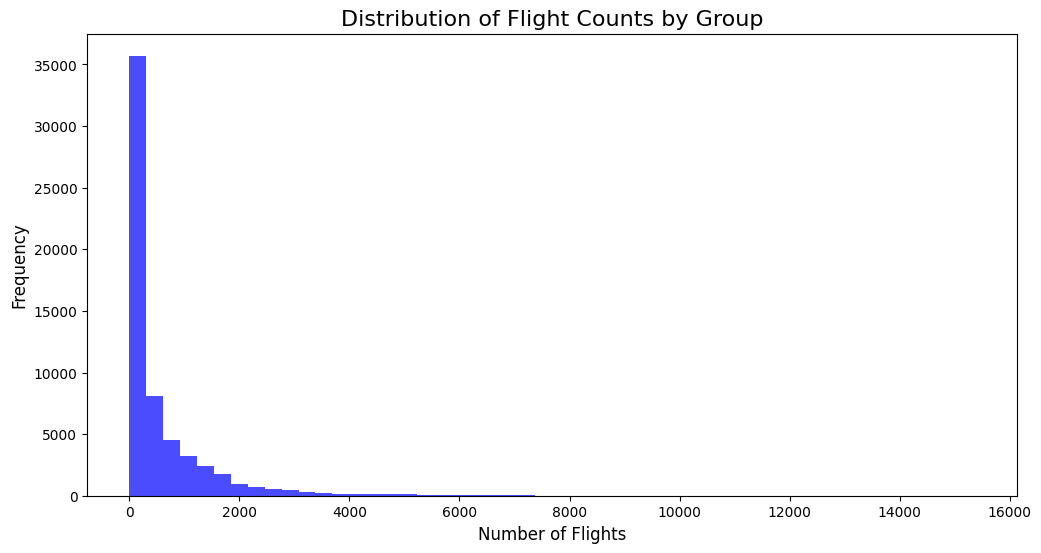

In [44]:
# plot the distribution of counts in grouped
plt.figure(figsize=(12, 6))
plt.hist(grouped, bins=50, color='b', alpha=0.7)
plt.title('Distribution of Flight Counts by Group', fontsize=16)
plt.xlabel('Number of Flights', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [46]:
# figure out how many have size > 200
grouped[grouped > 200]

OP_CARRIER_AIRLINE_ID  ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  DEP_TIME_BUCKET
19393                  10140              10423            afternoon           867
                                                           morning            1031
                                          10800            afternoon           583
                                          10821            afternoon           589
                                                           morning             555
                                                                              ... 
21171                  14771              12889            afternoon           268
                                          12892            afternoon           304
                                                           evening             245
                                                           morning             360
                                          14679            afternoon           261
Length: 2937

In [47]:
# get the top 5 groups
top_groups = grouped[grouped > 200].sort_values(ascending=False).head(5)
top_groups

OP_CARRIER_AIRLINE_ID  ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID  DEP_TIME_BUCKET
19690                  12173              13830            afternoon          15367
                       13830              12173            morning            15229
                       12173              13830            morning            14038
                       13830              12173            afternoon          13239
                       12758              12173            afternoon          12161
dtype: int64

In [50]:
df.groupby(['OP_CARRIER_AIRLINE_ID', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).size().sort_values(ascending=False).head(5)

OP_CARRIER_AIRLINE_ID  ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID
19690                  12173              13830              37533
                       13830              12173              37475
                       12173              12982              26831
                       12758              12173              26813
                       12982              12173              26807
dtype: int64

In [51]:
df.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).size().sort_values(ascending=False).head(5)

ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID
14771              12892              60232
12892              14771              60225
                   12889              50114
12889              12892              50045
12953              13930              49393
dtype: int64

/var/folders/z8/1d183zgx3c11zg5s3n3byg700000gn/T/ipykernel_48715/709309231.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  top_group_df = df.loc[top_group]


Text(0, 0.5, 'Density')

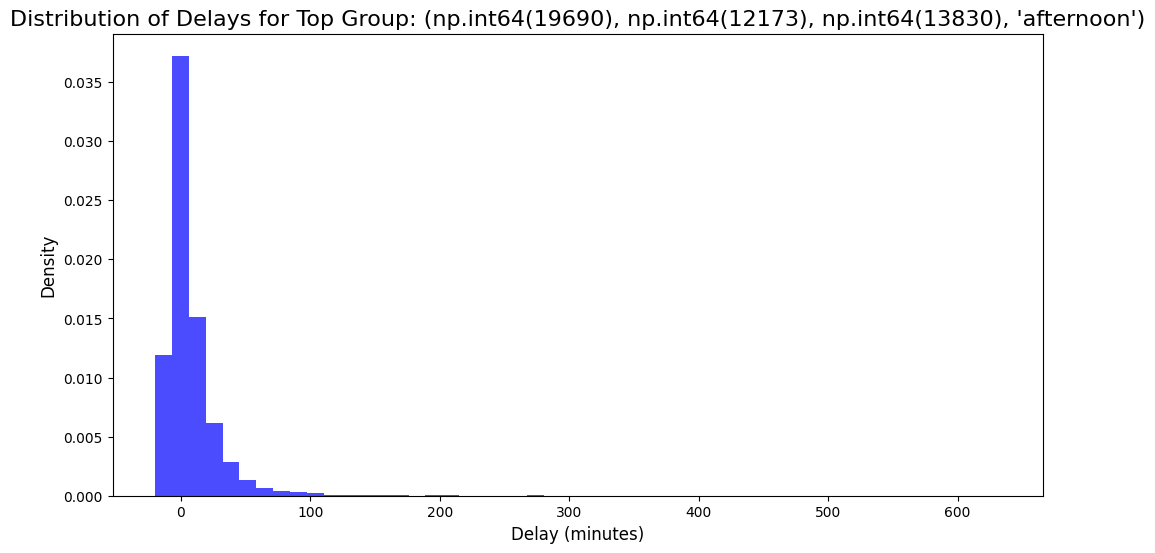

In [52]:
# filter for the to group from top_groups and plot the distribution of delays
top_group = top_groups.index[0]
top_group_df = df.loc[top_group]
plt.figure(figsize=(12, 6))
plt.hist(top_group_df[DELAY_COLUMN], bins=50, color='b', alpha=0.7, density=True)
plt.title(f"Distribution of Delays for Top Group: {top_group}", fontsize=16)
plt.xlabel('Delay (minutes)', fontsize=12)
plt.ylabel('Density', fontsize=12)

In [59]:
top_group_df[top_group_df[DELAY_COLUMN] > 0].shape[0] / top_group_df.shape[0]

0.543892757207002

Text(0, 0.5, 'Density')

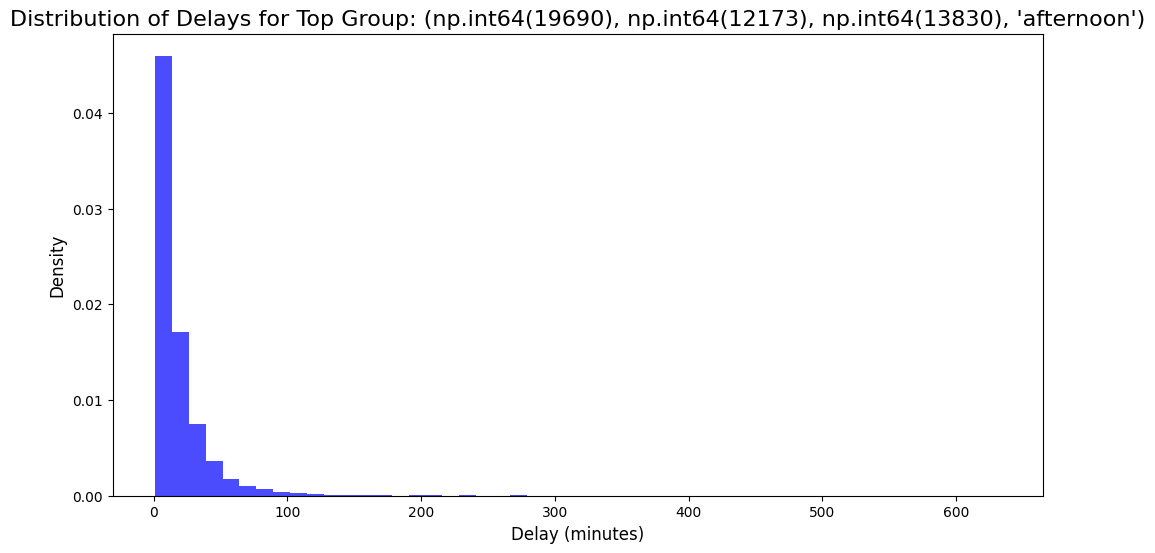

In [60]:
filtered_df = top_group_df[top_group_df[DELAY_COLUMN] > 0]
plt.figure(figsize=(12, 6))
plt.hist(filtered_df[DELAY_COLUMN], bins=50, color='b', alpha=0.7, density=True)
plt.title(f"Distribution of Delays for Top Group: {top_group}", fontsize=16)
plt.xlabel('Delay (minutes)', fontsize=12)
plt.ylabel('Density', fontsize=12)

In [54]:
# load lookup tables for airport
AIRPORT_LOOKUP_FILE = os.path.join(data_dir, 'lookup', 'L_AIRPORT_ID.csv')

# read the airport lookup table
airport_codes = pd.read_csv(AIRPORT_LOOKUP_FILE)
airport_codes.head(5)

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"


In [55]:
airport_codes = airport_codes.set_index('Code')

In [58]:
travel_counts = df.groupby(['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']).size().sort_values(ascending=False)

# get top 50 travel counts
top_travel_counts = travel_counts.head(50)

# get the airport description for each origin and dest airport id in top_travel_counts
top_travel_counts = top_travel_counts.reset_index()
top_travel_counts['ORIGIN_AIRPORT'] = top_travel_counts['ORIGIN_AIRPORT_ID'].map(airport_codes['Description'])
top_travel_counts['DEST_AIRPORT'] = top_travel_counts['DEST_AIRPORT_ID'].map(airport_codes['Description'])

top_travel_counts = top_travel_counts.drop(columns=["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"])
top_travel_counts


,0,ORIGIN_AIRPORT,DEST_AIRPORT
0,60232,"San Francisco, CA: San Francisco International","Los Angeles, CA: Los Angeles International"
1,60225,"Los Angeles, CA: Los Angeles International","San Francisco, CA: San Francisco International"
2,50114,"Los Angeles, CA: Los Angeles International","Las Vegas, NV: Harry Reid International"
3,50045,"Las Vegas, NV: Harry Reid International","Los Angeles, CA: Los Angeles International"
4,49393,"New York, NY: LaGuardia","Chicago, IL: Chicago O'Hare International"
5,49303,"Chicago, IL: Chicago O'Hare International","New York, NY: LaGuardia"
6,49180,"Honolulu, HI: Daniel K Inouye International","Kahului, HI: Kahului Airport"
7,49103,"Kahului, HI: Kahului Airport","Honolulu, HI: Daniel K Inouye International"
8,47036,"New York, NY: John F. Kennedy International","Los Angeles, CA: Los Angeles International"
9,46894,"Los Angeles, CA: Los Angeles International","New York, NY: John F. Kennedy International"
